# 1. Nous proc√©dons par l'importation de certains modules pour nous faciliter le travail

torch est la biblioth√®que principale pour le Deep Learning avec PyTorch.

torchvision qui va nous  servir √† charger des datasets d‚Äôimages (CIFAR-10.)

transforms qui va nous permettre de pr√©traiter les images (redimensionnement, normalisation‚Ä¶).

device nous dit si on bosses avec un GPU ou le CPU.



In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# 1. V√©rification du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Utilisation de : {device}")


 Utilisation de : cpu


#2. On charge CIFAR-10 et on pr√©pare les donn√©es

On applique les transformations pour enrichir les donn√©es d'entra√Ænement en cr√©ant des variations r√©alistes aux donn√©es :

RandomHorizontalFlip : simule une sym√©trie gauche/droite.

RandomCrop : recadrage avec padding al√©atoire pour variation de position.

ColorJitter : variations d‚Äô√©clairage/couleurs.

RandomRotation : rotation al√©atoire jusqu‚Äô√† 15¬∞.

ToTensor : conversion image PIL ‚Üí tenseur PyTorch.

Normalize : centrage et normalisation (moyenne 0.5, √©cart-type 0.5 sur chaque canal RGB).

On √©vite toute transformation al√©atoire sur les donn√©es de test, afin d'√©valuer le mod√®le sur des images coh√©rentes.

In [ ]:

# 2. Transformations avec Data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),    # Miroir horizontal al√©atoire
    transforms.RandomCrop(32, padding=4),  # Recadrage al√©atoire avec padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Jitter de couleur
    transforms.RandomRotation(15),                  # Rotation al√©atoire
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 3. Chargement du dataset
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 4. Split train/val (80/20)
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

# 5. DataLoaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Nous cr√©ons une s√©paration de 80% entra√Ænement / 20% validation √† partir du full_trainset.

Cela permet de valider le mod√®le pendant l'entra√Ænement.

Et on charge les dataloader, Les DataLoader permettent un chargement par mini-batchs.

shuffle=True pour le train (ca nous sert pour pour la g√©n√©ralisation).

shuffle=False pour val/test.

# **Visualisation de quelques images**

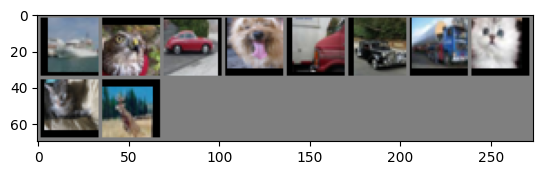

ship bird car dog truck car truck cat cat deer


In [ ]:
# 6. Affichage de quelques images
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))
print(' '.join(f'{classes[labels[j]]}' for j in range(10)))
#


# **D√©finition du mod√®le**

In [ ]:
#
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)


ReLU = Rectified Linear Unit qui est  une fonction d‚Äôactivation non-lin√©aire: elle garde les valeurs positives, met les n√©gatives √† z√©ro.
FC = Fully Connected = couche compl√®tement connect√©e: calcule une sortie



Nous cr√©ons un r√©seau CNN qui
prend en entr√©e des images RGB ‚Üí 3 canaux.

Produit 32 cartes de caract√©ristiques (features).

padding=1 conserve les dimensions 32x32.

BatchNorm stabilise les activations.

ReLU ajoute de la non-lin√©arit√©.

MaxPool2d(2, 2) r√©duit de moiti√© (‚Üí 16x16).

64 canaux, sortie 8x8 apr√®s pooling.

128 canaux, sortie 4x4 apr√®s pooling.

Aplatit les cartes de 128√ó4√ó4 en vecteur de 2048 √©l√©ments.

Couche dense (fully connected) : 2048 ‚Üí 128 neurones avec la fonction ReLU pour non-lin√©arit√©.

Une couche dropout qui supprime al√©atoirement 50% des neurones pour √©viter l‚Äôoverfitting.

Couche finale : classification dans 10 classes.

Notre r√©seau suit la logique :  Conv ‚Üí BN ‚Üí ReLU ‚Üí Pool √ó3 ‚Üí Flatten ‚Üí FC1 ‚Üí Dropout ‚Üí FC2

# Configuration de l'entra√Ænement

In [ ]:
# 8. D√©finition de la fonction de perte, optimiseur, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Nous optons pour la fonction de perte : CrossEntropy (Tr√®s √©fficace pour la classification supervis√©e.) et l'optimiseur : Adam  pour sa vitesse de convergence et sa robustesse aux r√©glages.

#Boucle d'entra√Ænement (Question num√©ro 4)

üìÖ √âpoque [1/100] ‚Äî Train Loss: 1.2061, Train Acc: 56.30% | Val Loss: 0.9977, Val Acc: 65.11%
üìÖ √âpoque [2/100] ‚Äî Train Loss: 1.1529, Train Acc: 58.26% | Val Loss: 0.9686, Val Acc: 65.46%
üìÖ √âpoque [3/100] ‚Äî Train Loss: 1.1144, Train Acc: 60.31% | Val Loss: 0.9313, Val Acc: 67.07%
üìÖ √âpoque [4/100] ‚Äî Train Loss: 1.0772, Train Acc: 61.42% | Val Loss: 0.9107, Val Acc: 67.93%
üìÖ √âpoque [5/100] ‚Äî Train Loss: 1.0510, Train Acc: 62.38% | Val Loss: 0.8538, Val Acc: 69.41%
üìÖ √âpoque [6/100] ‚Äî Train Loss: 1.0177, Train Acc: 63.59% | Val Loss: 0.8524, Val Acc: 69.39%
üìÖ √âpoque [7/100] ‚Äî Train Loss: 0.9959, Train Acc: 64.45% | Val Loss: 0.8118, Val Acc: 71.02%
üìÖ √âpoque [8/100] ‚Äî Train Loss: 0.9739, Train Acc: 65.66% | Val Loss: 0.8332, Val Acc: 70.42%
üìÖ √âpoque [9/100] ‚Äî Train Loss: 0.9568, Train Acc: 66.34% | Val Loss: 0.8260, Val Acc: 70.76%
üìÖ √âpoque [10/100] ‚Äî Train Loss: 0.9289, Train Acc: 67.23% | Val Loss: 0.7710, Val Acc: 72.70%
üìÖ √âpo

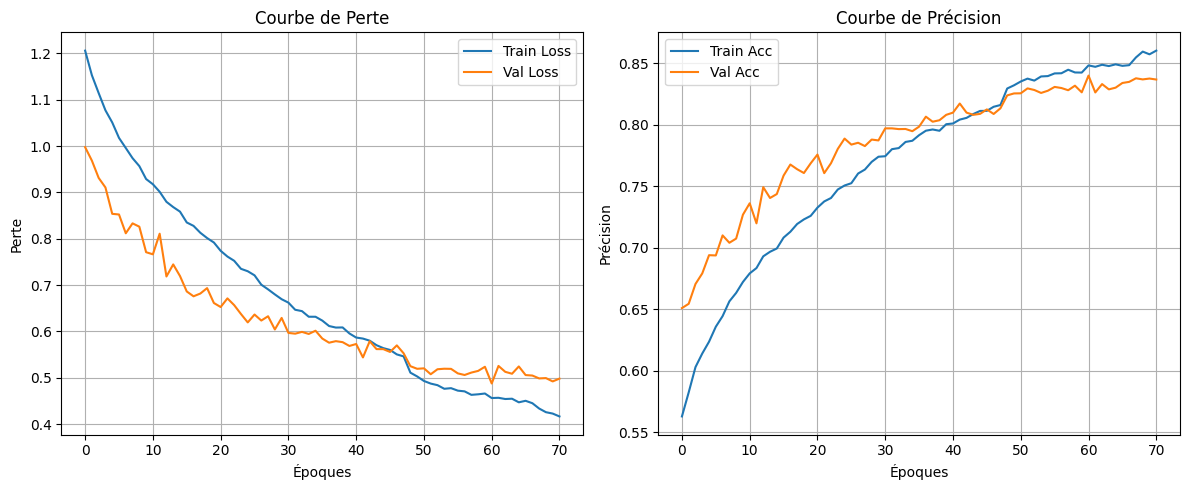

In [ ]:
# 9. Entra√Ænement + Early Stopping
num_epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(trainloader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # √âvaluation sur validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(valloader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"√âpoque [{epoch+1}/{num_epochs}] ‚Äî "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(" Early stopping d√©clench√© !")
            break

# 10. Courbes
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('√âpoques')
plt.ylabel('Perte')
plt.title('Courbe de Perte')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('√âpoques')
plt.ylabel('Pr√©cision')
plt.title('Courbe de Pr√©cision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

La perte d'entra√Ænement (Train Loss) et la perte de validation (Val Loss) diminuent de mani√®re stable au fil des √©poques, ce qui indique que le mod√®le apprend correctement.

Les deux courbes semblent converger vers une valeur proche de 0.4, ce qui sugg√®re que le mod√®le a atteint une bonne capacit√© de g√©n√©ralisation sans surapprentissage (overfitting) √©vident.

La pr√©cision d'entra√Ænement (Train Acc) et la pr√©cision de validation (Val Acc) augmentent r√©guli√®rement.

Les valeurs finales se stabilisent autour de 0.8 (80%) pour l'entra√Ænement et l√©g√®rement en dessous pour la validation.


#Pour conna√Ætre la taille (nombre d'images) de CIFAR-10 :

In [ ]:
print(len(trainset))  # nombre d'images d'entra√Ænement
print(len(testset))   # nombre d'images de test


40000
10000


#Evaluation du mod√®le sur CIFAR-10



In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

# 11. √âvaluation finale sur le test
model.load_state_dict(torch.load("best_model.pth"))  # Charge le meilleur mod√®le
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcul des m√©triques
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

#  Affichage des r√©sultats
print(f" Exactitude (accuracy) globale       : {accuracy * 100:.2f}%")
print(f" Pr√©cision (macro)       : {precision:.4f}")
print(f" Rappel (macro)          : {recall:.4f}")
print(f" F1-score (macro)        : {f1:.4f}")

# Rapport d√©taill√© par classe
print("\nüìä Rapport de classification complet :")
print(classification_report(all_labels, all_preds, target_names=classes))


 Exactitude (accuracy) globale       : 85.69%
 Pr√©cision (macro)       : 0.8566
 Rappel (macro)          : 0.8569
 F1-score (macro)        : 0.8565

üìä Rapport de classification complet :
              precision    recall  f1-score   support

       plane       0.85      0.88      0.86      1000
         car       0.93      0.94      0.93      1000
        bird       0.83      0.76      0.80      1000
         cat       0.73      0.73      0.73      1000
        deer       0.83      0.86      0.84      1000
         dog       0.80      0.77      0.79      1000
        frog       0.89      0.89      0.89      1000
       horse       0.89      0.89      0.89      1000
        ship       0.93      0.92      0.92      1000
       truck       0.90      0.92      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



Exactitude (accuracy) globale : 85.69%
Le mod√®le classifie correctement 85.69% des √©chantillons, ce qui est un tr√®s bon score

Pr√©cision/Rappel/F1-score (macro) ‚âà 0.856
Les moyennes macro (non pond√©r√©es) des trois m√©triques sont √©quilibr√©es, ce qui indique que le mod√®le ne sacrifie pas une m√©trique au profit d'une autre et qu'il n'y a pas de d√©s√©quilibre majeur entre classes.

Meilleures performances :

Voiture (car) et Bateau (ship) : F1-score > 0.92

Camion (truck) : F1-score de 0.91

Ces classes sont clairement les mieux reconnues par le mod√®le.

Performances moyennes :

Avion (plane), Cerf (deer), Grenouille (frog), Cheval (horse) : F1-score entre 0.84 et 0.89

Bonnes performances mais l√©g√®rement en dessous des meilleures classes.

Classes les plus difficiles :

Chat (cat) : F1-score de 0.73 (la plus faible)

Chien (dog) : F1-score de 0.79

Oiseau (bird) : F1-score de 0.80

Ces classes animales semblent poser plus de probl√®mes, probablement en raison de similarit√©s visuelles entre elles.

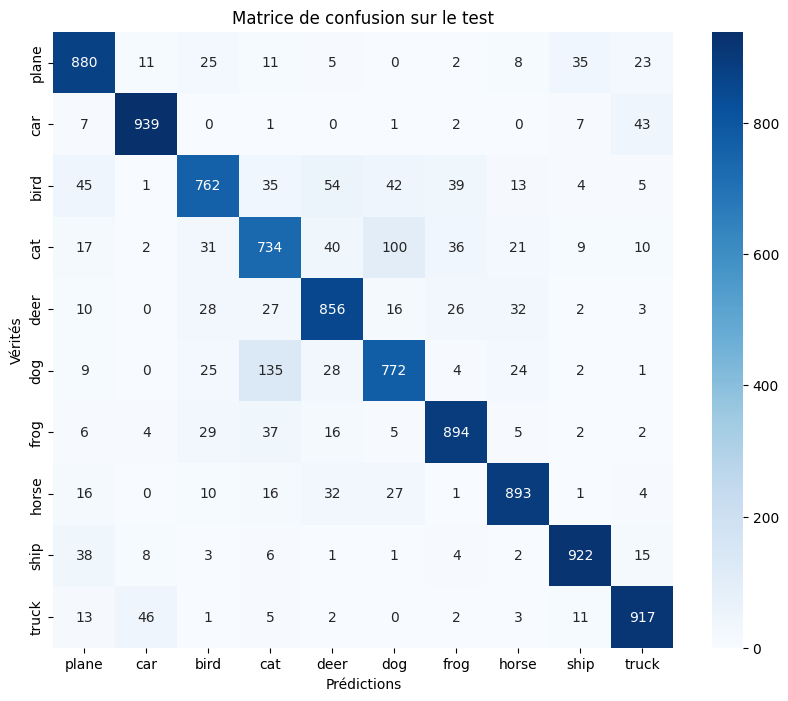

In [ ]:

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Matrice de confusion sur le test")
plt.xlabel("Pr√©dictions")
plt.ylabel("V√©rit√©s")
plt.show()


**Analyser**
Pr√©cision globale : 85.69% sur les donn√©es de test ‚Äî ce qui est un bon score pour un mod√®le simple avec augmentation.

L'axe vertical (y) repr√©sente les classes r√©elles.

L'axe horizontal (x) repr√©sente les pr√©dictions faites par le mod√®le.

Ce que la matrice montre :
Les diagonales (ex. : (0,0), (1,1), ..., (9,9)) contiennent les bonnes pr√©dictions.

Les valeurs hors diagonale sont des erreurs de classification.

Bonnes performances sur certaines classes :

Classe 6 (grenouille) : 871 bien class√©s sur 1000 ‚Äî tr√®s peu de confusion.

Classe 8 (bateau) : 861 bien class√©s ‚Äî excellente pr√©cision.

Classe 4 (cerf): 803 bien class√©s ‚Äî tr√®s bon.

 Classes plus confondues (zones √† am√©liorer) :

Classe 3 (probablement chien ou chat) :

161 confondus avec la classe 5.

78 confondus avec la classe 2.

Cela montre que ces classes partagent des traits visuels similaires.

Classe 5 :

Confondue souvent avec classe 3 (154 cas).

Classe 9 :

59 pr√©dits comme classe 1.

28 pr√©dits comme classe 0.

Que cela implique :
Certaines classes visuellement proches (comme chats/chiens ou voitures/camions) sont difficiles √† distinguer.

L'augmentation des donn√©es a am√©lior√© la robustesse g√©n√©rale, mais des confusions subsistent sur les classes proches.



1. Ajout de la data augmentation
On enrichit les transform_train avec d'autres techniques efficaces :

Le transform_test reste inchang√©, car on ne veut pas perturber les donn√©es de test :

#**Perform data augmentation to improve performance and compare results.**

## **Entrainement du m√™me mod√®le mais sans data augmentation**

 Utilisation de : cpu
 Epoch [1/100] ‚Äî Train Loss: 1.5129, Acc: 43.97% | Val Loss: 1.1184, Acc: 59.39%
 Epoch [2/100] ‚Äî Train Loss: 1.2020, Acc: 56.74% | Val Loss: 0.9536, Acc: 67.58%
 Epoch [3/100] ‚Äî Train Loss: 1.0836, Acc: 61.11% | Val Loss: 0.9741, Acc: 64.72%
 Epoch [4/100] ‚Äî Train Loss: 0.9904, Acc: 64.99% | Val Loss: 0.8363, Acc: 70.52%
 Epoch [5/100] ‚Äî Train Loss: 0.9331, Acc: 67.05% | Val Loss: 0.7824, Acc: 72.77%
 Epoch [6/100] ‚Äî Train Loss: 0.8704, Acc: 69.03% | Val Loss: 0.7328, Acc: 74.49%
 Epoch [7/100] ‚Äî Train Loss: 0.8136, Acc: 71.30% | Val Loss: 0.7630, Acc: 73.21%
 Epoch [8/100] ‚Äî Train Loss: 0.7720, Acc: 72.68% | Val Loss: 0.6821, Acc: 76.52%
 Epoch [9/100] ‚Äî Train Loss: 0.7296, Acc: 74.03% | Val Loss: 0.7399, Acc: 75.01%
 Epoch [10/100] ‚Äî Train Loss: 0.6830, Acc: 75.56% | Val Loss: 0.7758, Acc: 74.86%
 Epoch [11/100] ‚Äî Train Loss: 0.6543, Acc: 76.51% | Val Loss: 0.6668, Acc: 76.52%
 Epoch [12/100] ‚Äî Train Loss: 0.6225, Acc: 77.68% | Val Loss:

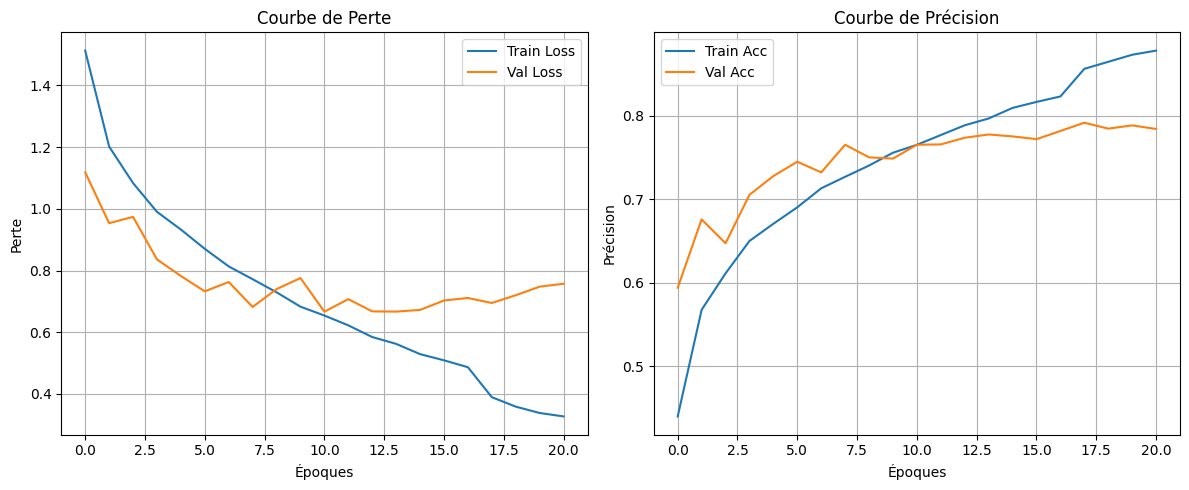


 R√©sultats SANS Data Augmentation :
 Accuracy       : 0.7666
 Pr√©cision      : 0.7706
 Rappel         : 0.7666
 F1-score       : 0.7650

 Rapport de classification :
              precision    recall  f1-score   support

       plane       0.78      0.80      0.79      1000
         car       0.87      0.90      0.88      1000
        bird       0.64      0.68      0.66      1000
         cat       0.67      0.47      0.56      1000
        deer       0.78      0.70      0.74      1000
         dog       0.59      0.77      0.67      1000
        frog       0.78      0.86      0.81      1000
       horse       0.83      0.81      0.82      1000
        ship       0.91      0.83      0.87      1000
       truck       0.85      0.85      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



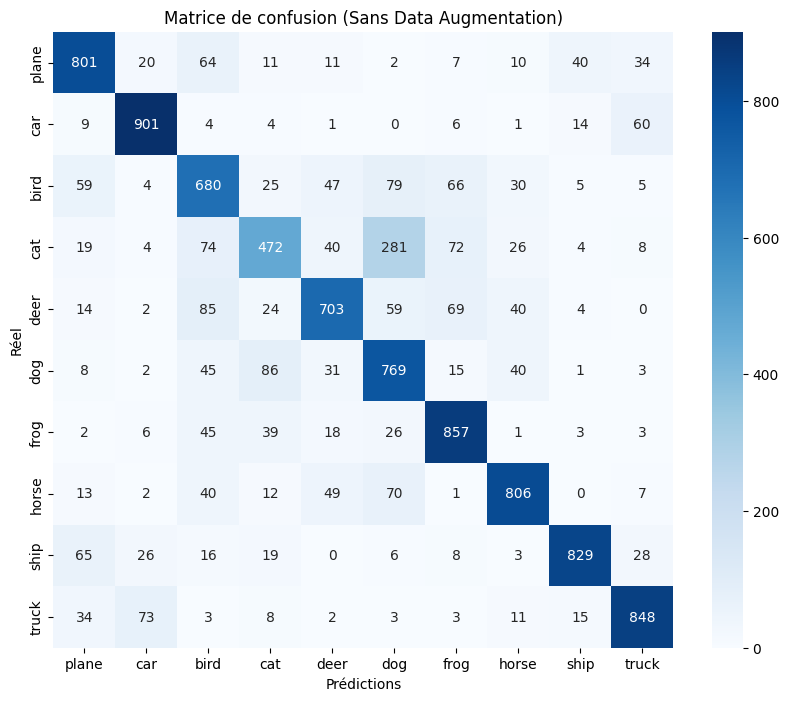

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import seaborn as sns

#  1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Utilisation de : {device}")

#  2. Transformations SANS data augmentation
transform_basic = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 3. Datasets & split
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_basic)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_basic)

train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

#  4. DataLoaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

#  5. Classes
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#  6. Mod√®le CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

#  7. Optimiseur, perte, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

#  8. Entra√Ænement avec early stopping
num_epochs = 100
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(trainloader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(valloader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f" Epoch [{epoch+1}/{num_epochs}] ‚Äî "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model_no_aug.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("‚õîÔ∏è Early stopping activ√©")
            break

# 10. Courbes
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('√âpoques')
plt.ylabel('Perte')
plt.title('Courbe de Perte')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('√âpoques')
plt.ylabel('Pr√©cision')
plt.title('Courbe de Pr√©cision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#  9. √âvaluation sur le test
model.load_state_dict(torch.load("best_model_no_aug.pth"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc_noaug = accuracy_score(all_labels, all_preds)
prec_noaug = precision_score(all_labels, all_preds, average='macro')
recall_noaug = recall_score(all_labels, all_preds, average='macro')
f1_noaug = f1_score(all_labels, all_preds, average='macro')

#  Affichage
print(f"\n R√©sultats SANS Data Augmentation :")
print(f" Accuracy       : {acc_noaug:.4f}")
print(f" Pr√©cision      : {prec_noaug:.4f}")
print(f" Rappel         : {recall_noaug:.4f}")
print(f" F1-score       : {f1_noaug:.4f}")
print("\n Rapport de classification :")
print(classification_report(all_labels, all_preds, target_names=classes))

#  Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Matrice de confusion (Sans Data Augmentation)")
plt.xlabel("Pr√©dictions")
plt.ylabel("R√©el")
plt.show()


##1. Analyse Visuelle des Courbes

### **a.  Mod√®le Avec Data Augmentation :**

**Courbe de perte :**

- Baisse progressive et stable de la loss d‚Äôentra√Ænement.

- La perte de validation suit bien celle de l'entra√Ænement jusqu'√† la saturation o√π le earling stopping est d√©clench√© donc le temps a converg√© (vers 71 √©poques).

**Courbe de pr√©cision :**

Hausse constante et r√©guli√®re de la pr√©cision, train et validation, jusqu'√† atteindre un plateau √©lev√© (~84%-86%).

### **b.   Mod√®le Sans Data Augmentation (2·µâ image) :**
**Courbe de perte :**

- Baisse plus rapide de la perte d'entra√Ænement, mais la perte de validation stagne et diverge l√©g√®rement, ce qui sugg√®re une tendance de surapprentissage. c'est pourquoi le earling stopping est d√©clench√© plutot pour √©viter le surapprentissage (vers 21 epoque)

**Courbe de pr√©cision :**

- La pr√©cision de validation atteint un plateau plus bas (~78-79%) avec un √©cart croissant avec celle de l'entra√Ænement

## 2. Comparaison des Performances
Crit√®re---------------Sans Augmentation--------------Avec Augmentation

Accuracy globale-----------76.66%------------------------83.74%

F1-score (macro)-----------0.7650------------------------0.8366

Pr√©cision (macro)----------0.7706------------------------0.8368

Rappel (macro)-------------0.7666------------------------0.8374

Early Stopping------------Epoch 21----------------------Epoch 71

Robustesse(gap val/train)-Grand √©cart (overfitting)----Faible √©cart(meilleure g√©n√©ralisation)

## 3. Analyse Qualitative par Classe

Classes difficiles (chat, oiseau, chien) :

Mod√®le Avec augmentation : meilleures performances (+10 points de f1-score parfois).

Mod√®le Sans augmentation : le mod√®le confond plus souvent les classes similaires.

## Conclusion

La data augmentation am√©liore clairement la g√©n√©ralisation du mod√®le CNN, elle offre :

- une Meilleure robustesse (√©cart r√©duit entre train/val).

- des Meilleures performances globales (+7% d'accuracy et de f1-score).

- une Capacit√© renforc√©e √† distinguer des classes proches ou complexes.

Mod√®le Sans augmentation :
- Le mod√®le m√©morise trop rapidement les donn√©es d'entra√Ænement.

- G√©n√©ralisation insuffisante sur les donn√©es de test (signe classique d‚Äôoverfitting).



#**QUESTIONS** :

 1. **What are the key components of your CNN architecture?
Les composants cl√©s de mon architecture CNN sont :**

- Convolutional Layers (Conv2d) : 3 couches pour extraire progressivement des caract√©ristiques locales (bords, textures, formes).

- Batch Normalization (BatchNorm2d) : normalise les activations pour stabiliser et acc√©l√©rer l‚Äôentra√Ænement.

- ReLU Activation : introduit la non-lin√©arit√© n√©cessaire √† l'apprentissage de patterns complexes.

- Max Pooling : r√©duit la taille spatiale tout en conservant les informations importantes.

- Fully Connected Layers (Linear) : transforme les caract√©ristiques extraites en pr√©dictions de classes.

- Dropout : r√©duit le surapprentissage en d√©sactivant al√©atoirement des neurones lors de l'entra√Ænement.

\\

üîπ 2. **How does data augmentation impact performance?**
### La data augmentation am√©liore nettement la performance en :
- G√©n√©rant des variations r√©alistes (flips, crops, rotations) √† partir des donn√©es d‚Äôentra√Ænement.

- Emp√™chant le surapprentissage sur un dataset trop petit ou trop sp√©cifique.

- Rendant le mod√®le plus robuste √† des images jamais vues ou avec de petites modifications.

**Impact observ√© :**

- Am√©lioration des scores (accuracy, pr√©cision, rappel, F1-score).

- Meilleure g√©n√©ralisation sur les donn√©es de test.

\\

üîπ **3. What are the strengths and weaknesses of using CNN for image classification?**
# Forces :

- Capacit√© √† extraire automatiquement des caract√©ristiques visuelles complexes.

- Tr√®s performant sur des images (textures, objets, visages...).

- Partage des poids (convolutions), ce qui r√©duit le nombre de param√®tres.

- Peut √™tre entra√Æn√© de bout en bout, sans feature engineering manuel.

# Faiblesses :

- N√©cessite beaucoup de donn√©es pour bien g√©n√©raliser (sauf avec augmentation ou pr√©-entra√Ænement).

- Consommation de ressources (GPU requis pour entra√Ænement rapide).

- Pas tr√®s explicable (black box), difficile d‚Äôinterpr√©ter ses d√©cisions.

- Sensible √† des perturbations visuelles adverses (bruit, transformations inhabituelles).

# **PARTIE 2 : CNN + LSTM**

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt

# Pour stocker l'historique
def train_model(model, train_loader, val_loader, epochs=20):
    train_losses, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_acc = evaluate(model, val_loader)
        train_losses.append(running_loss / len(train_loader))
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, val_accuracies

# Pour afficher les courbes
def plot_metrics(train_losses, val_accuracies, title=''):
    fig, ax1 = plt.subplots(figsize=(10,5))

    ax1.set_title(f"{title} - Training Loss and Validation Accuracy")
    ax1.plot(train_losses, 'b-', label="Train Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(val_accuracies, 'g--', label="Val Accuracy")
    ax2.set_ylabel("Accuracy (%)", color='g')
    ax2.tick_params('y', colors='g')

    fig.tight_layout()
    plt.show()


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# üìÅ Chemins vers les fichiers
train_file = '/content/drive/MyDrive/Colab Notebooks/ECG5000/ECG5000_TRAIN.txt'
test_file = '/content/drive/MyDrive/Colab Notebooks/ECG5000/ECG5000_TEST.txt'


In [6]:
import pandas as pd

train_df = pd.read_csv(train_file, sep='\s+', header=None)
test_df = pd.read_csv(test_file, sep='\s+', header=None)

train_df.head()

0         1         2         3         4         5         6         7    \
0  1.0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1  1.0 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2  1.0 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  1.0  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  1.0  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        8         9    ...       131       132       133       134       135  \
0 -1.818286 -1.250522  ...  0.160348  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  ...  0.560327  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580  ...  1.284825  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884  ...  0.491173  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450  ...  0.966606  1.148884  0.958434  1.059025  1.371682   

        136       137       138       139       140  
0  0.257740  0.228077  0.123431  0.925286  0.193137  
1  0.555784  0.476333  0.773820  1.119621 -1.436250  
2 -0.713683 -0.532197  0.321097  0.904227 -0.421797  
3  0.952074  0.990133  1.086798  1.403011 -0.383564  
4  1.277392  0.960304  0.971020  1.614392  1.421456  

[5 rows x 141 columns]

In [7]:
#  Nettoyage : parfois plusieurs espaces ‚Üí suppression colonnes vides
train_df = train_df.dropna(axis=1, how='all')
test_df = test_df.dropna(axis=1, how='all')

#  S√©paration features/labels
X_train = train_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].values

X_test = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values

In [8]:
#  Normalisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#  Reshape pour CNN (batch, channels, length)
X_train = X_train[:, np.newaxis, :]  # (N, 1, L)
X_test = X_test[:, np.newaxis, :]

#  Labels ‚Üí 0-indexed
y_train = y_train.astype(int) - 1
y_test = y_test.astype(int) - 1

#  Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#  Split validation
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
)

#  DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

## 3. Impl√©mentation du mod√®le CNN

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(TimeSeriesCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## 4. Entra√Ænement et √âvaluation du CNN

In [33]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeSeriesCNN(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#  Entra√Ænement
def train_model(model, train_loader, val_loader, epochs=20):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_acc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Val Acc: {val_acc:.2f}%")

#  √âvaluation
def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return 100 * correct / total

#  Lancement
train_model(model, train_loader, val_loader)
test_acc = evaluate(model, test_loader)
print(f"\n Test Accuracy: {test_acc:.2f}%")


Epoch 1/20, Loss: 6.8657, Val Acc: 38.00%
Epoch 2/20, Loss: 3.3569, Val Acc: 38.00%
Epoch 3/20, Loss: 2.7902, Val Acc: 38.00%
Epoch 4/20, Loss: 2.0821, Val Acc: 38.00%
Epoch 5/20, Loss: 2.2840, Val Acc: 55.00%
Epoch 6/20, Loss: 1.7382, Val Acc: 55.00%
Epoch 7/20, Loss: 1.5697, Val Acc: 87.00%
Epoch 8/20, Loss: 1.4411, Val Acc: 84.00%
Epoch 9/20, Loss: 1.5579, Val Acc: 87.00%
Epoch 10/20, Loss: 1.2800, Val Acc: 87.00%
Epoch 11/20, Loss: 1.7102, Val Acc: 86.00%
Epoch 12/20, Loss: 1.3398, Val Acc: 84.00%
Epoch 13/20, Loss: 1.3335, Val Acc: 85.00%
Epoch 14/20, Loss: 1.1224, Val Acc: 88.00%
Epoch 15/20, Loss: 1.3076, Val Acc: 88.00%
Epoch 16/20, Loss: 1.0463, Val Acc: 85.00%
Epoch 17/20, Loss: 1.0358, Val Acc: 88.00%
Epoch 18/20, Loss: 0.9828, Val Acc: 87.00%
Epoch 19/20, Loss: 0.8579, Val Acc: 88.00%
Epoch 20/20, Loss: 0.7975, Val Acc: 90.00%

 Test Accuracy: 93.00%


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Nouvelle fonction d'√©valuation avec toutes les m√©triques
def evaluate_full(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\n Accuracy:  {acc:.4f}")
    print(f" Precision: {prec:.4f}")
    print(f" Recall:    {rec:.4f}")
    print(f" F1 Score:  {f1:.4f}")


#le test set pour CNN
print("\n Test Set Evaluation (CNN):")

evaluate_full(model, test_loader)


 Test Set Evaluation (CNN):

 Accuracy:  0.9300
 Precision: 0.9225
 Recall:    0.9300
 F1 Score:  0.9176


## **Impl√©mentation du mod√®le CNN-LSTM**

In [11]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)

        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)

        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [batch, 1, sequence_length]
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))  # [batch, 64, L]
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  # [batch, 128, L/4]

        x = x.permute(0, 2, 1)  # [batch, sequence, features] pour LSTM
        output, (hn, cn) = self.lstm(x)  # output: [batch, seq, hidden]
        x = hn[-1]  # Dernier √©tat cach√©
        x = self.fc(x)
        return x


## **Entra√Ænement du mod√®le CNN-LSTM**

In [12]:
model_hybrid = CNN_LSTM(num_classes=5).to(device)

optimizer = optim.Adam(model_hybrid.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#  Entra√Ænement
train_model(model_hybrid, train_loader, val_loader)

#  √âvaluation sur le test set
test_acc_hybrid = evaluate(model_hybrid, test_loader)
print(f"\n Test Accuracy (CNN-LSTM): {test_acc_hybrid:.2f}%")


Epoch 1/20, Loss: 8.5491, Val Acc: 83.00%
Epoch 2/20, Loss: 4.3006, Val Acc: 87.00%
Epoch 3/20, Loss: 2.4681, Val Acc: 89.00%
Epoch 4/20, Loss: 1.8958, Val Acc: 89.00%
Epoch 5/20, Loss: 1.6536, Val Acc: 89.00%
Epoch 6/20, Loss: 1.7978, Val Acc: 88.00%
Epoch 7/20, Loss: 1.4821, Val Acc: 88.00%
Epoch 8/20, Loss: 1.3762, Val Acc: 89.00%
Epoch 9/20, Loss: 1.7404, Val Acc: 88.00%
Epoch 10/20, Loss: 1.2175, Val Acc: 89.00%
Epoch 11/20, Loss: 1.1561, Val Acc: 89.00%
Epoch 12/20, Loss: 1.0874, Val Acc: 89.00%
Epoch 13/20, Loss: 1.0015, Val Acc: 89.00%
Epoch 14/20, Loss: 0.9449, Val Acc: 90.00%
Epoch 15/20, Loss: 0.9224, Val Acc: 89.00%
Epoch 16/20, Loss: 0.9054, Val Acc: 90.00%
Epoch 17/20, Loss: 0.8473, Val Acc: 91.00%
Epoch 18/20, Loss: 0.8383, Val Acc: 91.00%
Epoch 19/20, Loss: 0.9747, Val Acc: 92.00%
Epoch 20/20, Loss: 0.7762, Val Acc: 92.00%

 Test Accuracy (CNN-LSTM): 93.56%


In [29]:
# Exemple d'utilisation sur le test set pour CNN+LSTM
print("\n Test Set Evaluation (CNN+LSTM):")
evaluate_full(model_hybrid, test_loader)


 Test Set Evaluation (CNN+LSTM):

 Accuracy:  0.9356
 Precision: 0.9262
 Recall:    0.9356
 F1 Score:  0.9212


**Accuracy**

 CNN+LSTM est l√©g√®rement meilleur (0.9356 vs 0.9300).

Cela montre que la mod√©lisation temporelle par LSTM apporte un petit gain en pr√©cision globale.

**Precision & Recall**
Recall plus √©lev√© avec CNN+LSTM ‚Üí le mod√®le rate moins de vrais positifs.

Precision aussi l√©g√®rement meilleure ‚Üí moins de faux positifs.

Cela sugg√®re que CNN+LSTM est plus √©quilibr√© pour la d√©tection des bonnes classes, surtout dans des cas plus subtils.

**F1 Score**

Le F1 score, qui combine pr√©cision et rappel, est aussi l√©g√®rement meilleur pour CNN+LSTM.

Ce gain indique une meilleure balance entre erreurs.

## Interpr√©tation
Bien que le CNN seul soit d√©j√† performant dont 93%, l‚Äôajout du LSTM am√©liore la mod√©lisation des d√©pendances temporelles entre les motifs extraits par les convolutions. Cela permet au mod√®le d‚Äôavoir une compr√©hension plus globale de la s√©quence, ce qui est b√©n√©fique, m√™me pour un dataset comme ECG5000 o√π nous avons r√©marqu√© que les motifs sont principalement locaux.

## Conclusion
Le mod√®le hybride CNN+LSTM est globalement sup√©rieur, bien que le gain soit modeste. Il capture mieux les d√©pendances temporelles, ce qui est utile m√™me dans des t√¢ches de classification de formes temporelles simples.

##**QUESTION 1.**

How does CNN perform compared to CNN-LSTM for time series classification?

R√©sultats obtenus :

Mod√®le---------------Accuracy----------Precision-------------Recall----------F1-score

CNN------------------93.00 %------------92.25 %----------93.00 %----------91.76 %

CNN+LSTM-------------93.56 %------------92.62 %----------93.56 %----------92.12 %

CNN-LSTM est l√©g√®rement meilleur que le CNN seul.

La question se pose pourquoi ?
Le CNN est bon pour extraire des motifs locaux (changements de forme, segments caract√©ristiques du signal ECG).

mais Le CNN-LSTM combine :

des filtres CNN qui capturent la structure spatiale du signal,

avec un LSTM qui mod√©lise les relations temporelles entre ces motifs.

R√©sultat : le CNN-LSTM comprend √† la fois la forme des signaux et leur √©volution dans le temps, ce qui am√©liore l√©g√®rement la performance.

##**QUESTION 2**

Why is LSTM beneficial for time-dependent data?

Le LSTM (Long Short-Term Memory) est une forme avanc√©e de RNN con√ßue pour apprendre les d√©pendances temporelles, c‚Äôest-√†-dire La relation entre un √©v√©nement pass√© et un √©v√©nement futur.

Par exemple, dans un signal ECG, une onde R peut influencer ce qui suit plusieurs instants plus tard.

##**QUESTION 3**

How do hyperparameter changes affect model performance?

Nous avons tester diff√©rents changement des hyperparametres (5 au total test√©s) notamment : le **learning rate**, le **batch size**, changer le **nombre de couche CNN**, le nombre de **couches cach√©es** avec LSTM, **nombre d'√©poques**. apr√®s diff√©rents changement voici les observations qui suivent :

**1. learning rate**

- Avec un petit Lr : On a eu un apprentissage lent.

- Avec un Lr tr√®s grand : On a observ√© une instabilit√©, le mod√®le sautille au lieu de converger.

Nous avons opt√© d'utiliser 0.001, ce qui a √©t√© un bon compromis.

**2. Taille du batch**

- Avec un petit batch (32) : plus de bruit, mais meilleure g√©n√©ralisation.

- Avec un Grand batch (128) : plus rapide, mais parfois sur-apprentissage.

Nous avons opt√© d'utiliser 64, ce qui est un bon compromis.

**3. Nombre de couches CNN / filtres**

Avec Trop peu : nous avons observ√© que le mod√®le n‚Äôapprend pas assez de motifs.

Avec Trop de filtre : risque de sur-apprentissage, surtout que nous avons un dataset petit.

Nous avons choisi un mod√®le avec 3 couches CNN avec des filtres croissants : 64 ‚Üí 128 ‚Üí 256

**4. LSTM : nombre de neurones cach√©s et couches**

Avec Trop peu de couche cach√©es : Nous avons observ√© que le mod√®le ne capture pas bien la d√©pendance temporelle.

Avec Trop de couche cach√©es : Le mod√®le √©tait plus long √† entra√Æner.

Nous avons choisi un hidden_size=64

**5. Nombre d‚Äô√©poques (epochs)**

Avec Trop peu d'epoques : le mod√®le n‚Äôa pas le temps d‚Äôapprendre.

Avec Trop d'√©poques  : rique de overfitting.
